In [306]:
# import class for financial data
import yfinance as yf

# import class for data manipulation and analysis
import pandas as pd
import numpy as np

# import class for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#import class for machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# import class for evaluation metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# import class for connection to broker 
from ib_insync import *
import nest_asyncio

# import class(s) for supportive functions
import datetime as dt
from scipy.stats import randint, uniform


In [223]:
current_date = dt.datetime.now().strftime('%Y-%m-%d')
ticker = 'NVDA'
df = yf.download(ticker, start = '2020-01-01', end = current_date)

[*********************100%***********************]  1 of 1 completed


In [224]:
df.columns = ['close', 'high', 'low', 'open', 'volume']

In [225]:
%%markdown 
## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



In [ ]:
df['5MA_Returns'] = df['close'].rolling(window=5).mean().pct_change(periods=5)
df['15MA_Returns'] = df['close'].rolling(window=15).mean().pct_change(periods=15)
df['50MA_Returns'] = df['close'].rolling(window=50).mean().pct_change(periods=50)
df['5Volatility'] = df['close'].rolling(window=5).std()
df['next_close'] = df['close'].shift(-1)
df.dropna(inplace=True)
df

,close,high,low,open,volume,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,next_close
Date,,,,,,,,,,
2020-05-26,8.685749,9.148047,8.640167,9.123138,770780000,0.084221,0.142570,0.097290,0.131916,8.493956
2020-05-27,8.493956,8.601060,7.967395,8.593339,1175892000,0.051545,0.150902,0.112287,0.201071,8.455848
2020-05-28,8.455848,8.728343,8.348492,8.381371,734896000,0.011255,0.156003,0.123458,0.216071,8.842919
2020-05-29,8.842919,8.842919,8.453853,8.523098,745256000,-0.003654,0.164813,0.138385,0.228282,8.773925
2020-06-01,8.773925,8.808298,8.657604,8.800826,389876000,-0.020653,0.168523,0.151717,0.170218,8.792856
...,...,...,...,...,...,...,...,...,...,...
2025-05-19,135.570007,135.869995,132.389999,132.389999,193154600,0.142014,0.149474,-0.141653,2.410673,134.380005
2025-05-20,134.380005,134.580002,132.619995,134.289993,161514200,0.118392,0.157188,-0.133194,0.489825,131.800003
2025-05-21,131.800003,137.399994,130.589996,133.059998,270608700,0.079850,0.162347,-0.125483,1.525951,132.830002


In [227]:
df.describe()

,close,high,low,open,volume,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,next_close
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,47.450585,48.348827,46.459850,47.450767,4.257626e+08,0.012673,0.038493,0.141897,1.385725,47.551472
std,43.119048,43.954301,42.221326,43.172075,1.810562e+08,0.057618,0.104982,0.207470,1.668273,43.176593
min,8.455848,8.601060,7.967395,8.381371,9.788400e+07,-0.154879,-0.229242,-0.279930,0.041952,8.455848
25%,15.346696,15.664219,15.091277,15.339960,2.907080e+08,-0.026497,-0.032071,-0.000879,0.373552,15.350925
50%,24.670668,25.211653,23.965027,24.759766,4.036860e+08,0.014594,0.028001,0.146866,0.692824,24.684675
75%,76.174965,78.545503,74.192142,74.996840,5.248180e+08,0.051517,0.109066,0.308947,1.643660,77.633858
max,149.416245,153.115916,147.806407,153.015919,1.543911e+09,0.252968,0.336621,0.597735,12.714196,149.416245


In [261]:
df_corr = df[['5MA_Returns', '15MA_Returns', '50MA_Returns', '5Volatility', 'close', 'next_close']].corr()
df_corr

,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,close,next_close
5MA_Returns,1.000000,0.310539,0.096020,-0.035512,0.043059,0.042330
15MA_Returns,0.310539,1.000000,0.298758,-0.036306,0.023010,0.023155
50MA_Returns,0.096020,0.298758,1.000000,-0.002936,0.063340,0.063472
5Volatility,-0.035512,-0.036306,-0.002936,1.000000,0.779466,0.779583
close,0.043059,0.023010,0.063340,0.779466,1.000000,0.998661
next_close,0.042330,0.023155,0.063472,0.779583,0.998661,1.000000


In [262]:
def find_highest_correlation_pair(df):
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_series = upper_triangle.stack()
    max_corr_index = corr_series.abs().idxmax()
    return max_corr_index, corr_series[max_corr_index]

highest_corr_pair, highest_corr_value = find_highest_correlation_pair(df[df_corr.columns])
print(f'Highest correlation pair: {highest_corr_pair} with correlation value: {highest_corr_value:.2f}')

Highest correlation pair: ('close', 'next_close') with correlation value: 1.00


In [285]:
x_train, x_test, y_train, y_test = train_test_split(
    df[df_corr.columns[:-1]],
    #df,  
    df['next_close'], 
    test_size=0.2, 
    shuffle=False
    )

In [287]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [293]:
abs_mae_lr = mean_absolute_error(y_test, y_pred)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f'Linear Regression Mean Absolute Error: {abs_mae_lr:.2f}')
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression R^2: {r2_lr:.2f}')

Linear Regression Mean Absolute Error: 3.39
Linear Regression RMSE: 4.53
Linear Regression R^2: 0.87


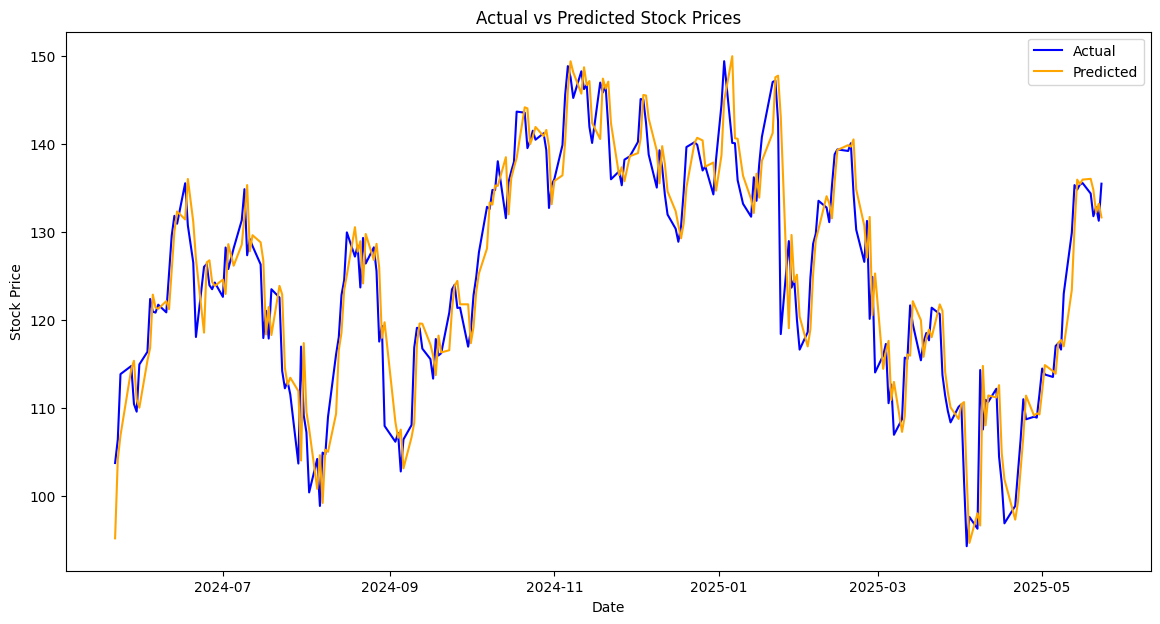

In [294]:
plt.figure(figsize=(14, 7))
plt.plot(x_test.index, y_test, label='Actual', color='blue')
plt.plot(x_test.index, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Text(0, 0.5, 'Predicted Values')

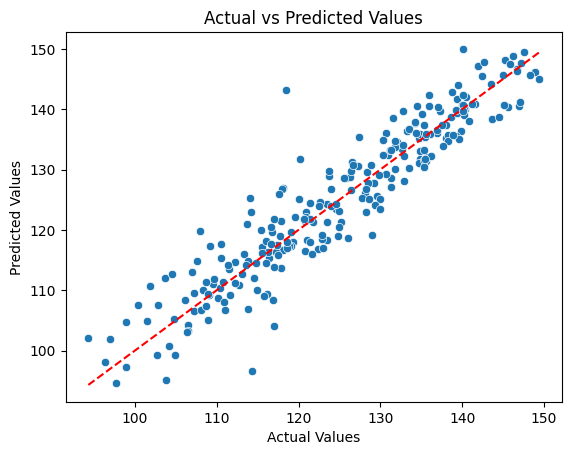

In [ ]:
act_val = lr.score(x_train, y_train)
predict_val = lr.score(x_test, y_test)
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x = np.linspace(y_test.min(), y_test.max(), 100), 
             y = np.linspace(y_test.min(), y_test.max(), 100), 
             color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

Text(0, 0.5, 'Residuals')

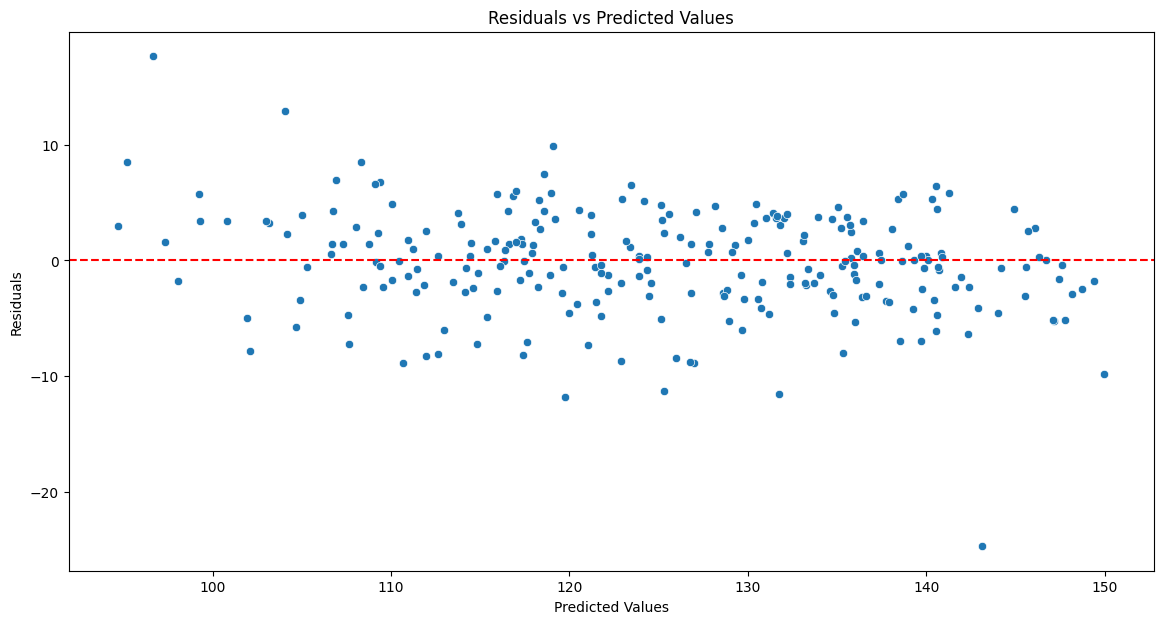

In [301]:
residuals = y_test - y_pred
plt.figure(figsize=(14, 7))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

<Figure size 1400x700 with 0 Axes>

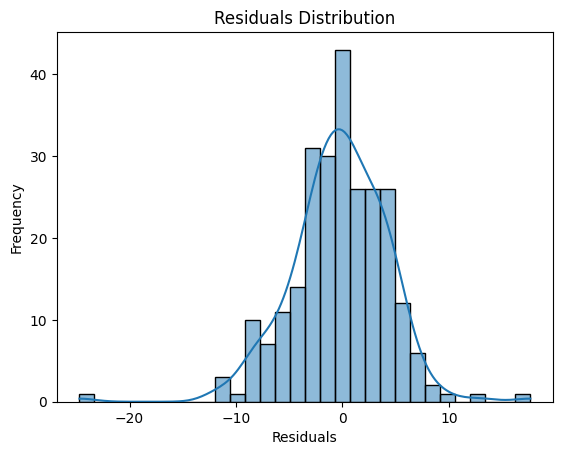

<Figure size 1400x700 with 0 Axes>

In [305]:
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.figure(figsize=(14, 7))


Text(0, 0.5, 'Sample Quantiles')

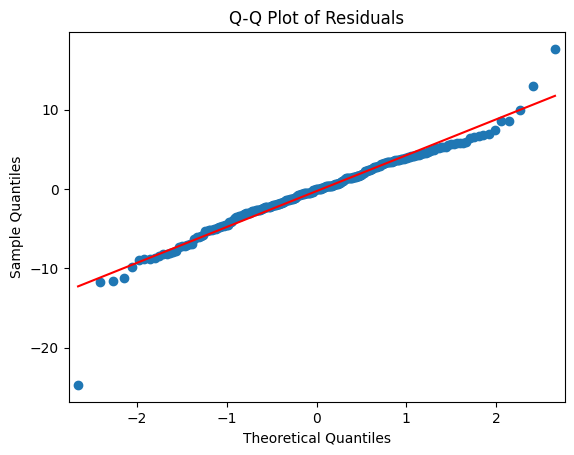

In [308]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

In [177]:
#TODO 7: Create buy and sell signals based on predictions

In [178]:
#TODO 8: Visualize the buy and sell signals on the stock price chart

In [179]:
#TODO 9: Evaluate the model's performance using Sharpe Ratio, total return vs buy and hold strategy.

In [180]:
#TODO 10: Using the buy and sell signals to send orders to the broker